In [1]:
# --- Imports ---
import os
import pandas as pd
import random
from PIL import Image
import torch
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- Paths ---
dataset_path = '/content/drive/MyDrive/Major Project Final/dataset2.csv'

# --- Category list ---
categories = [
    'Baddie', 'bday', 'beaches', 'Cafe', 'Cats', 'CHRISTMAS',
    'couples', 'desi', 'diwali', 'Dogs', 'Mirror', 'Monsoon',
    'mountain', 'Skyyy', 'Sunkissed','Friends']

In [4]:
category_prompts = {
    'Baddie': "A stylish baddie aesthetic",
    'bday': "A cheerful birthday celebration",
    'beaches': "A scenic beach view",
    'Cafe': "A cozy cafe scene",
    'Cats': "A cute cat moment",
    'CHRISTMAS': "A festive Christmas celebration",
    'couples': "A romantic couple moment",
    'desi': "A vibrant cultural desi experience",
    'diwali': "A sparkling Diwali celebration",
    'Dogs': "A playful dog moment",
    'Mirror': "A mirror selfie aesthetic",
    'Monsoon': "A beautiful monsoon scene",
    'mountain': "A breathtaking mountain view",
    'Skyyy': "A picturesque sky view",
    'Sunkissed': "A sunkissed golden hour moment",
    'Friends' : "A group of friends makes life better"
}

In [5]:
# List of categories and matching prompts
categories = list(category_prompts.keys())
text_prompts = list(category_prompts.values())

In [6]:
# --- Load the dataset ---
df = pd.read_csv(dataset_path)

In [7]:
# --- Prepare category-based caption mappings ---
category_captions = {category: [] for category in categories}

In [8]:
for _, row in df.iterrows():
    image_path = row[0]
    captions = row[1:6].tolist()  # Ensure only 5 captions are taken

    # Determine category based on image path
    matched = False
    for category in categories:
        if category.lower() in image_path.lower():
            category_captions[category].extend(captions)
            matched = True
            break
    if not matched:
        print(f"Warning: No category matched for image {image_path}")


<ipython-input-8-53247a1ea13b>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]


In [9]:
# --- Load CLIP model and processor ---
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [10]:
# --- Preprocess image function ---
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

In [11]:
# --- Function to predict the category of an image ---
def predict_category(image_path):
    image = Image.open(image_path).convert("RGB")

    # Process the image and text prompts with CLIP
    inputs = clip_processor(text=text_prompts, images=image, return_tensors="pt", padding=True)
    outputs = clip_model(**inputs)

    # Calculate similarity
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = torch.cosine_similarity(image_features, text_features)

    # Get most similar category
    predicted_idx = torch.argmax(similarity).item()
    predicted_category = categories[predicted_idx]

    print(f"Predicted category: {predicted_category} (Score: {similarity[predicted_idx].item():.4f})")
    return predicted_category

In [12]:
# --- Function to get 5 random captions from a category ---
def get_captions_for_category(category):
    if category in category_captions:
        captions = category_captions[category]
        if len(captions) >= 5:
            return random.sample(captions, 5)
        elif captions:
            return captions  # return all if less than 5
    print(f"No captions found for category '{category}'")
    return []

In [13]:
# --- Main function to process an input image ---
def generate_captions(image_path):
    category = predict_category(image_path)
    captions = get_captions_for_category(category)

    print(f"\nGenerated Captions for '{category}':")
    for idx, cap in enumerate(captions, 1):
        print(f"{idx}. {cap}")

    return category, captions

In [14]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/cat_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: Cats (Score: 0.2866)

Generated Captions for 'Cats':
1. Soft but not subtle.
2. Pawsitivity overload.
3. Curl, purr, conquer.
4. Unleashing the floof.
5. Sassy, classy, a little bit catty.


In [ ]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/dog_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: Dogs (Score: 0.2428)

Generated Captions for 'Dogs':
1. Some angels have paws.
2. Paw-some from nose to tail.
3. Certified belly rub specialist.
4. This pup is my happy place.
5. Adopt, don't shop!


In [ ]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/christ_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: CHRISTMAS (Score: 0.2639)

Generated Captions for 'CHRISTMAS':
1. Time to get into the Christmas spirit.
2. Dear Santa, Is it Too Late Now to Say Sorry?
3. Wish you a Merry and Bright Christmas.
4. What do you get when you cross a snowman and a vampire? Frostbite!
5. Naughty list? More like spice list.


In [ ]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/diwali_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: diwali (Score: 0.2957)

Generated Captions for 'diwali':
1. Sparkling brighter than my bangles 💎💫
2. Diwali runway ready 🏃‍♀️💃
3. Glow
4. Who needs fireworks when you're already a blast?
5. Desi attire, festive fire!


In [ ]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/sky_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: Skyyy (Score: 0.2798)

Generated Captions for 'Skyyy':
1. Astrophile
2. a piece of peace
3. Friendly reminder: Everything will be okay, even if it doesn't feel like it right now
4. Eyes on the sky, heart in the clouds
5. sweetest time of the day


In [ ]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/monsoon_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: Monsoon (Score: 0.2961)

Generated Captions for 'Monsoon':
1. Monsoon, where are you?
2. 37.-Grey clouds, rainy skies -
3. In the monsoon, let’s chase waterfalls and dreams.
4. let's meet up, tell stories while watching rain falls
5. after the rain>>>>


In [ ]:
# --- Test with sample image ---
image_path = '/content/drive/MyDrive/sample/bday_sample.jpg'
category, captions = generate_captions(image_path)

Predicted category: bday (Score: 0.2804)

Generated Captions for 'bday':
1. Turned my birthday into a lifestyle 🌟👑
2. I wish some nights lasted forever 🌙✨
3. [age] years later and I'm still standing on business 💼🔥
4. Birthday bliss meets aesthetic chic 🎉👗
5. Same time next year ⏳🔄


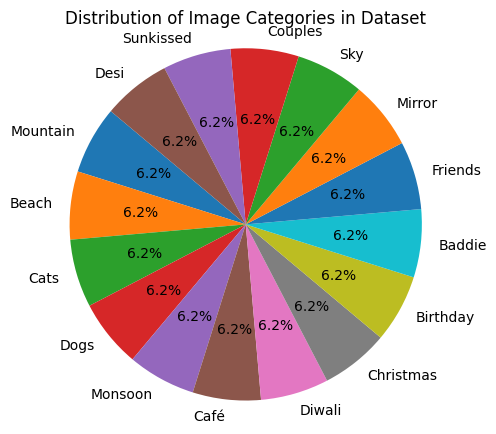

In [16]:
import matplotlib.pyplot as plt

# Example category distribution (replace with your actual values)
categories = [
    'Mountain', 'Beach', 'Cats', 'Dogs', 'Monsoon', 'Café', 'Diwali', 'Christmas',
    'Birthday', 'Baddie', 'Friends', 'Mirror', 'Sky', 'Couples', 'Sunkissed', 'Desi'
]
image_counts = [
    100, 100, 100, 100, 100, 100, 100, 100,
    100, 100, 100, 100, 100, 100, 100, 100
]  # Replace with actual count per category

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(image_counts, labels=categories, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Image Categories in Dataset')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


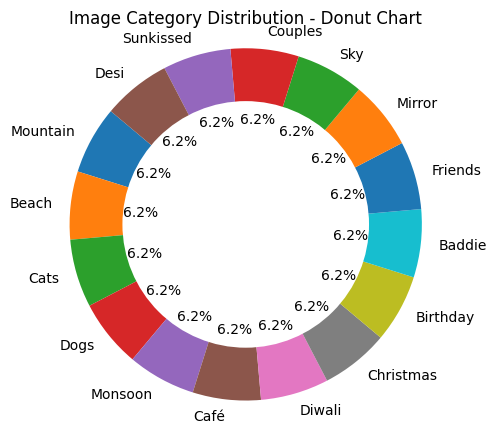

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(image_counts, labels=categories, autopct='%1.1f%%', startangle=140)
# Draw circle for donut effect
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.title('Image Category Distribution - Donut Chart')
plt.axis('equal')
plt.show()